In [2]:
import json
import numpy as np

In [9]:
gt_file = "global_explanations_full.json"

global_samples = 2000
samples_nums = [10, 20, 50, 100, 200, 500, 1000]
sampled_files = [f"global_explanations_{i}.json" for i in samples_nums]
gt_results = json.load(open(gt_file))
sampled_results = {i: json.load(open(f)) for i, f in zip(samples_nums, sampled_files)}

In [10]:
def get_top_k_tokens_per_category(analysis_results: dict, k = 10):
    top_k_tokens = {}
    for category in analysis_results:
        tokens = analysis_results[category]
        tokens = [(t, v) for t, v in tokens.items()]
        tokens = sorted(tokens, key=lambda x: np.abs(x[1]), reverse=True)
        tokens = tokens[:k]
        top_k_tokens[category] = {t: v for t, v in tokens}
    return top_k_tokens    
print("Top 10 tokens per category in ground truth")
print(get_top_k_tokens_per_category(gt_results))

Top 10 tokens per category in ground truth
{'joy': {'winning': 0.43570588093295254, 'entertained': 0.37442486525552654, 'decent': 0.3697268485076623, 'benevolent': 0.2481928904626182, 'convinced': 0.23762154741087654, 'delicious': 0.23095829389103584, 'innocent': 0.22696858699510652, 'unique': 0.22593244297165593, 'glad': 0.2228160014287642, 'cool': 0.22209815072871356}, 'sadness': {'defective': 0.947936092591327, 'sentimental': 0.8741461796528132, 'disadvantaged': 0.8704089204053199, 'tragic': 0.8185530525234761, 'inadequate': 0.8120993653718744, 'melancholy': 0.8045942373559802, 'aching': 0.7698456547689875, 'abused': 0.717048974027787, 'damaged': 0.7150775710000353, 'fake': 0.706181907567752}, 'anger': {'appalled': 0.7539517345453115, 'distracted': 0.6408279153974414, 'fucked': 0.6188905806282229, 'rebellious': 0.5958198078002498, 'aggravated': 0.5830096120201007, 'dissatisfied': 0.562194087521132, 'rushed': 0.5585160967075898, 'violent': 0.5512250672290656, 'angered': 0.55076837748

In [16]:
# compute MAE between top 10 results in ground truth and sampled results
def compute_mae_and_hit_rate(gt_results, sampled_results, top_k = 10):
    # computes MAE on top_k tokens per category
    # if a token from gt is not in sampled, it gets skipped in MAE computation
    # also computes how many tokens from top_k in gt are in top_k in sampled
    # sampled is dict for one sample rate
    mae = 0
    hit_rate = 0
    gt_top_k = get_top_k_tokens_per_category(gt_results, top_k)
    sampled_top_k = get_top_k_tokens_per_category(sampled_results, top_k)
    for category in gt_top_k:
        gt_tokens = gt_top_k[category]
        sampled_tokens = sampled_top_k[category]
        for token in gt_tokens:
            if token in sampled_tokens:
                hit_rate += 1
                mae += np.abs(gt_tokens[token] - sampled_tokens[token])
            # else:
            #     mae += np.abs(gt_tokens[token])
                
    return mae / hit_rate, hit_rate / (top_k * len(gt_top_k))
for num_samples, results_sampled in sampled_results.items():
    print(f"Sample rate: {num_samples}")
    print(f"MAE: {compute_mae_and_hit_rate(gt_results, results_sampled)}")
print(compute_mae_and_hit_rate(gt_results, gt_results))

Sample rate: 10
MAE: (np.float64(0.21317534528035764), 0.06666666666666667)
Sample rate: 20
MAE: (np.float64(0.1705402762242861), 0.08333333333333333)
Sample rate: 50
MAE: (np.float64(0.1417699720898445), 0.13333333333333333)
Sample rate: 100
MAE: (np.float64(0.12144750389368325), 0.21666666666666667)
Sample rate: 200
MAE: (np.float64(0.10219265667930413), 0.26666666666666666)
Sample rate: 500
MAE: (np.float64(0.11825336406620279), 0.5166666666666667)
Sample rate: 1000
MAE: (np.float64(0.0640994546109413), 0.65)
(np.float64(0.0), 1.0)


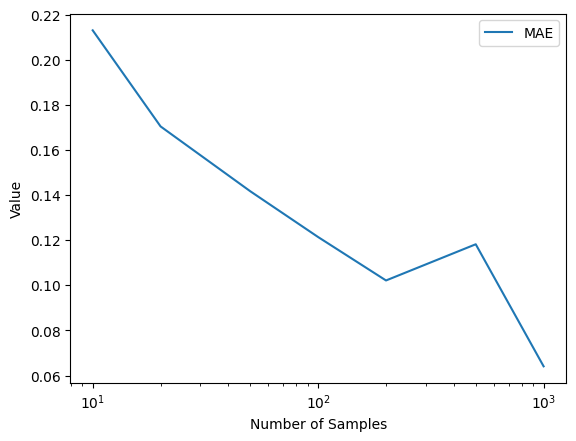

In [ ]:
# graph the results of mae and hit rate
import matplotlib.pyplot as plt
mae = []
hit_rate = []
for num_samples, results_sampled in sampled_results.items():
    m, h = compute_mae_and_hit_rate(gt_results, results_sampled)
    mae.append(m)
    hit_rate.append(h)
plt.plot(samples_nums, mae, label="MAE")
plt.title("MAE for top 10 tokens per category vs Number of Samples")
plt.xlabel("Number of Samples")
# x axis should be log scale
plt.xscale("log")
plt.ylabel("Value")
plt.legend()